# Classification multi


In [69]:
%reset -f

In [70]:
!pip install equinox

In [71]:
import tensorflow as tf

import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optax
import pickle
from dataclasses import dataclass
import time
from typing import Callable
import os
import shutil
import pandas as pd
import equinox as eqx

In [209]:
np.set_printoptions(precision=3,suppress=True,linewidth=1000000)

##  MNIST data



### import data

70 000 images de 28*28 pixel écrite à la main, représentant des chiffres à retrouver.

C'est le "Hello world" du machine learning.



In [73]:
X_raw={}
Y_raw={}

In [74]:
(X_raw["train"], Y_raw["train"]), (X_raw["test"], Y_raw["test"]) = tf.keras.datasets.mnist.load_data()

In [75]:
X_raw["train"].shape, Y_raw["train"].shape

In [76]:
X_raw["test"].shape, Y_raw["test"].shape

Créons un jeu de validation

In [77]:
n_train=50_000
X_raw["train"],X_raw["val"] = X_raw["train"][:n_train],X_raw["train"][n_train:]
Y_raw["train"],Y_raw["val"]= Y_raw["train"][:n_train],Y_raw["train"][n_train:]

### Observons le lien entre les data et les labels

In [78]:
def plot_XY(X,Y):
    ni=5
    nj=5
    fig,axs=plt.subplots(ni,nj,figsize=(2*nj,2*ni))
    for i in range(ni):
        for j in range(nj):
            k=i*nj+j
            axs[i,j].imshow(X[k,:,:])
            axs[i,j].set_title(f"{Y[k]}")
            axs[i,j].axis("off")

    fig.tight_layout()

plot_XY(X_raw["train"],Y_raw["train"])

### Passage dans le GPU

In [79]:
X={}
Y={}
for key in ["train","val","test"]:
    X[key] = jnp.array(X_raw[key])/255
    Y[key] = jnp.array(Y_raw[key]).astype(jnp.int32)

In [80]:
X["train"].dtype, Y["train"].dtype

Cela ne change rien à la "nature" de nos données

In [81]:
plot_XY(X["train"],Y["train"])

In [82]:
val,count=np.unique(Y["train"],return_counts=True)
plt.bar(val,count);
plt.xticks(val);

⇑ Les classes sont équilibrée. C'est une bonne chose => sinon

* Rééchantilloner

* Pondérer

* Utiliser des loss spéciales (ex: focal loss).

###  Classification Multi-classe d'image applatie

On va chercher à retrouver les labels à partir des images applaties.


Nous transformons chacune des images 2D un vecteur 1D

Transformons ces images en dataframe

In [83]:
X_flat={}
for key in ["train","val","test"]:
    X_flat[key] = jnp.array(X[key]).reshape([-1,28*28])

In [84]:
X_flat[key].shape

In [85]:
def plot_one_label(label):
    X_train_one=X_flat["train"][Y["train"]==label]
    plt.matshow(X_train_one[:200])

In [86]:
plot_one_label(0)

In [87]:
plot_one_label(1)

In [88]:
plot_one_label(2)

In [89]:
plot_one_label(3)

⇑ On voit que même  applatie, chaque label donne un signal avec un aspect  particulier, sans doute reconnaissable par un réseau de neurone.

## Tout pour l'entrainement


### Un modèle MLP

In [90]:
def model_fnm(hyper_param):

    dim_out=hyper_param["dim_out"]
    layer_widths=[784] + [hyper_param["dim_hidden"]]*hyper_param["n_layer"] + [dim_out]

    def model_init(rkey):
        params = []
        for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
            rk,rkey=jr.split(rkey)
            params.append(
                {"weight":jr.normal(rk,shape=(n_in, n_out))*jnp.sqrt(2/n_in),
                "bias":jnp.zeros([n_out])})
        return params


    @jax.jit
    def model_apply(params, inp):
        *hidden, last = params
        for layer in hidden:
            inp = jax.nn.relu(inp @ layer['weight'] + layer['bias'])
        return inp @ last['weight'] + last['bias']



    return model_init,model_apply


def test():
    model_init,model_apply=model_fnm({"dim_hidden":64,"n_layer":3,"dim_out":10})
    param=model_init(jr.key(0))
    X=jnp.ones([1,28*28])
    Y_pred=model_apply(param,X)
    print(Y_pred)
test()


***A vous:*** Comme d'habitude avec nos MLP, model_apply peut s'appliquer à un batch de donnée ou bien à une seule donnée.

### Distributeur de batch

In [91]:
"""  distributeur de donnée par batch.   """
def oneEpoch(X_all,Y_all,batch_size):

    nb_batches=len(X_all)//batch_size

    shuffle_index=np.random.permutation(len(X_all))
    X_all_shuffle=X_all[shuffle_index]
    Y_all_shuffle=Y_all[shuffle_index]

    for i in range(nb_batches):
        yield X_all_shuffle[i*batch_size:(i+1)*batch_size],Y_all_shuffle[i*batch_size:(i+1)*batch_size]

In [92]:
for x,y in oneEpoch(X_flat["train"],Y["train"],10_000):
    print(x.shape,y.shape)





###  Jit creator

In [155]:
def jit_creator(hyper_param):

    optimizer=optax.adam(hyper_param["learning_rate"])
    dim_out=hyper_param["dim_out"]
    model_init,model_apply= model_fnm(hyper_param)

    @jax.jit
    def loss_compute(params, X, Y_true):
        model_out=model_apply(params,X)
        possibilities=["multi_classif","binary_classif","regression_in_01","hard"]
        assert hyper_param["loss_for"] in possibilities, f"bad value for hyper_param['loss_for']. Possibilities are {possibilities}."

        if hyper_param["loss_for"] == "multi_classif":
            losses=optax.softmax_cross_entropy_with_integer_labels(model_out,Y_true)
        elif hyper_param["loss_for"] == "binary_classif":
            losses=optax.sigmoid_binary_cross_entropy(model_out,Y_true)
        elif hyper_param["loss_for"] == "regression_in_01":
            losses=(Y_true-jax.nn.sigmoid(model_out))**2
        elif hyper_param["loss_for"] == "hard":
            losses=optax.softmax_cross_entropy(model_out,Y_true)
        else:
            assert False
        return jnp.mean(losses)



    @jax.jit
    def update_model_param(optimizer_state, model_param, X,Y_true):
        loss,grads = jax.value_and_grad(loss_compute)(model_param, X,Y_true )
        updates, optimizer_state = optimizer.update(grads, optimizer_state)
        model_param = optax.apply_updates(model_param, updates)
        return loss,optimizer_state, model_param


    return model_init, model_apply, optimizer, loss_compute, update_model_param

### Fonctions de sauvegarde

In [156]:
def save_as_pickle(file_name,serializable):
    pickle.dump(serializable,open(file_name,"wb"))
def load_from_pickle(file_name):
    return pickle.load(open(file_name,"rb"))
def save_as_str(file_name,serializable):
    with open(file_name, "wt") as f:
        f.write(str(serializable))
def load_from_str(file_name):
    with open(file_name, "rt") as f:
        res = eval(f.read())
    return res

### L'Agent en personne

In [157]:
@dataclass
class AgentResult:
    hyper_param:dict
    best_loss:float
    model_param:dict

class Agent:
    @staticmethod
    def load(folder):
        assert os.path.exists(folder),f"folder:{folder} does not exist"
        model_param = load_from_pickle(f"{folder}/model_param")
        best_loss = load_from_str(f"{folder}/best_loss")
        model_param=load_from_pickle(f"{folder}/model_param")
        hyper_param=load_from_str(f"{folder}/hyper_param")
        return AgentResult(hyper_param,best_loss,model_param)



    @staticmethod
    def train(X_here,Y_here,folder,hyper_param,n_epoch,verbose=True):

        #on repart de zéro
        shutil.rmtree(folder,ignore_errors=True)
        os.makedirs(folder)

        losses=[]
        val_losses=[]
        val_steps=[]

        batch_size = hyper_param["batch_size"]
        model_init, model_apply, optimizer, loss_compute, update_model_param = jit_creator(hyper_param)



        if verbose:
            print(f"New folder:{folder}, model_param are randomly initialized")

        model_param=model_init(jr.key(0))

        best_loss=1e10#l'infini ou presque


        save_as_str(f"{folder}/hyper_param", hyper_param)
        optimizer_state=optimizer.init(model_param)

        step=0

        for _ in range(n_epoch):

            for x,y in oneEpoch(X_here["train"],Y_here["train"],batch_size):
                step+=1
                loss,optimizer_state, model_param = update_model_param(optimizer_state, model_param, x,y)
                losses.append(loss)

            val_loss=loss_compute(model_param, X_here["val"], Y_here["val"])
            val_steps.append(step)
            val_losses.append(val_loss)


            if val_loss <= best_loss:
                best_loss=val_loss
                save_as_pickle(f"{folder}/model_param",model_param)
                save_as_str(f"{folder}/best_loss",best_loss)

                if verbose:
                    print(f"⬊{val_loss:.3g}", end="")

            else:
                if verbose:
                    print(".",end="")
        if verbose:
            print("| end of the optimization loop.")

        return losses,val_losses,val_steps


## Classification multiclass, GO!

### Entrainement

In [100]:
hyper_param={"dim_hidden":64,"n_layer":4,"learning_rate":1e-3,"batch_size":512,
             "dim_out":10,"loss_for":"multi_classif"}
folder="data/multiclasses"
losses,val_losses,val_steps = Agent.train(X_flat,Y,folder,hyper_param,25)

In [101]:
fig,ax=plt.subplots()
ax.plot(losses,label="train")
ax.plot(val_steps,val_losses,".",label="val")
ax.set_yscale("log")
ax.legend();

### Accuracy

In [102]:
def accuracy(Y_true,Y_pred):
    return jnp.mean(Y_pred==Y_true)

accuracy(jnp.array([1,2,3,4]),jnp.array([0,0,3,4]))

In [104]:
result=Agent.load(folder)
_,model_apply=model_fnm(result.hyper_param)


def model_predict_labels(param,X_flat):
    Y_pred_proba=model_apply(param,X_flat)
    return jnp.argmax(Y_pred_proba,axis=-1)


Y_pred=model_predict_labels(result.model_param,X_flat["test"])
Y_pred.shape

In [105]:
accuracy(Y["test"],Y_pred)

⇑ 97% de bien classé sur le jeu test. Pas mal.  

##  Analyse de l'erreur

Bien sur, dans un projet complet de machine learning il faut:

* Tester différentes préparation des données (resclaling, ACP, suppression de valeurs abhérentes ...)

* Essayez différents modèles

* Garder les plus prometteurs

* ajuster les paramètres et sélectionner le modèle avec de la cross-validation et des recherche en grille ou aléatoire.

Et tout l'art est de trouver le bon compromis entre:

* tout automatiser (et risquer de mal comprendre les choses)
* tout faire à la main (et y passer toutes ses nuits)

Supposons que l'on a déjà choisi des modèles prometteurs. On aimerait analyser leur erreurs "à la main" pour tenter de les améliorer.

En premier lieu, il faut regarder la matrice de confusion

### Matrice de confusion

* Chaque ligne représente une vraie étiquette (`y_true`).
* Chaque colonne représente une étiquette prédite (`y_pred`)

Par exemple, sur la classification des chiffres, un modèle entrainé devrait donner ceci:

    [[ 965    0    1    1    0    1    3    3    4    2]
    [   0 1115    3    1    0    1    5    2    8    0]
    [   6    1  998    6    5    3    5    5    3    0]
    [   1    1   10  969    2   13    0    9    3    2]
    [   1    0    9    1  938    1    3    5    2   22]
    [   5    1    2   19    0  846    5    5    5    4]
    [   9    3    2    0    9   12  922    0    1    0]
    [   1    7   14    5    1    0    0  992    0    8]
    [   6    2    5   12    8   11    6    7  915    2]
    [   5    7    0    9   14    6    1   12    4  951]]

La lib `sklearn` permet de la calculer en une ligne:


    conf_mx = sklearn.metrics.confusion_matrix(y_test, y_pred)

Mais c'est aussi très facile à coder à la main.

***A vous:*** Faites un petit programme qui calcul cette matrice de confusion. C'est un bon exercice de programmation. Vous pouvez le faire  avec numpy ou avec torch, c'est quasi pareil.

Pour faire apparaitre des proportions: on divise chacune des valeurs par le nombre d'image dans la classe correspondante. ça devrait donner un truc comme ceci:

    [[0.98 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
    [0.   0.98 0.   0.   0.   0.   0.   0.   0.01 0.  ]
    [0.01 0.   0.97 0.01 0.   0.   0.   0.   0.   0.  ]
    [0.   0.   0.01 0.96 0.   0.01 0.   0.01 0.   0.  ]
    [0.   0.   0.01 0.   0.96 0.   0.   0.01 0.   0.02]
    [0.01 0.   0.   0.02 0.   0.95 0.01 0.01 0.01 0.  ]
    [0.01 0.   0.   0.   0.01 0.01 0.96 0.   0.   0.  ]
    [0.   0.01 0.01 0.   0.   0.   0.   0.96 0.   0.01]
    [0.01 0.   0.01 0.01 0.01 0.01 0.01 0.01 0.94 0.  ]
    [0.   0.01 0.   0.01 0.01 0.01 0.   0.01 0.   0.94]]



En notant $\imath$ les vraie instances de la $i$ème-classe et $\hat \imath$ les instances prédites dans cette même classe, nous avons tracé la matrice dont les coefficients sont:
$$
\frac {\imath \cap \hat \jmath}{\imath}
$$
Ainsi on a affiché une proportion qui, en classification binaire, s'appellerait:

* le rappel ?
* la précision ?



### En couleur



In [106]:
def plot_mat(conf_mx):
    plt.matshow(conf_mx)
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.grid(False)
    plt.colorbar()

Le problème c'est que la diagonale est très dominante. Astuce: mettez à zéro les coefficients diagonnaux pour mieux voir les non-diagonnaux. ça donnera un truc comme ceci:

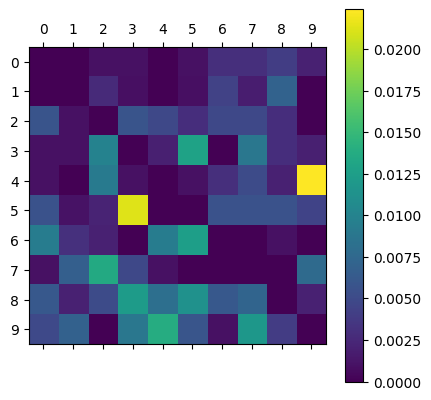

### En couleur et en nombre



In [107]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=True,
                          suppress_diag=False,
                          title="",
                          cmap="jet",
                          precision=3,
                         ):

    y_true=y_true.astype(int)
    y_pred=y_pred.astype(int)
    np.set_printoptions(precision=precision)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    classes=range(cm.shape[0])


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if suppress_diag:
        for i in range(len(classes)):
            cm[i,i]=0


    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    fig.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')


    # Loop over data dimensions and create text annotations.
    fmt = '.'+str(precision)+'f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "coral")
    fig.tight_layout()

In [108]:
plot_confusion_matrix(Y["test"],Y_pred,suppress_diag=True)


***A vous:*** Quels sont les chiffres que le modèle confond le plus ? Est-ce qu'il y a une certaine symétrie dans la confusion ?

Que peut-on faire

* rassembler plus de données correspondant à ces classes

* créer des features particulière qui permettent de les distinguer: ex: compter le nombre de composante connexe du complémetaire, ce qui différentie le 8, le 9, et le 5. Mais là on sort un peu du machine learning pour revenir aux algos classiques.

* Observer individuellement les erreurs pour voir s'il n'y a pas de problèmes d'étiquette, de valeurs abhérentes, des problèmes de normalisation etc.



### Observation individuelle des erreurs

***A vous:*** Que fait le programme suivant ? Testez-le avec des chiffre  confondus fréquemment par le modèle.

In [109]:
def see_confusions(class_true,class_pred,X,Y_true,Y_pred):
    X_ab = X[(Y_true == class_true) & (Y_pred == class_pred),:,:]

    ni=len(X_ab)
    fig,axs=plt.subplots(ni,1,figsize=(2,2*ni))
    if ni==1:
        axs=[axs]

    for i,ax in enumerate(axs):
        ax.imshow(X_ab[i,:,:])
        ax.axis("off")

In [110]:
see_confusions(8,3,X["test"],Y["test"],Y_pred)

In [111]:
see_confusions(5,3,X["test"],Y["test"],Y_pred)

In [112]:
see_confusions(3,5,X["test"],Y["test"],Y_pred)

##  Classification Multilabel

Parfois on doit poser plusieurs étiquettes sur une même donnée. ex:

* Une donnée = une photo avec plusieur visage. Les étiquettes:  "présence d'un homme", "présence d'une femme".  
* Une donnée = une photo avec 1 animal. Les étiquettes:  mamifère, insecte, lion, chat, mouche: ce sont des catégories non-disjointes.


###  Création des données

In [113]:
def make_multi_label(y):
    y_large = (y >= 7).astype(jnp.int32)
    y_odd = (y % 2 == 1).astype(jnp.int32)
    y_prime = ((y==2)|(y==3)|(y==5)|(y==7)).astype(jnp.int32)

    y_multilabel = jnp.stack([y_large, y_odd,y_prime],axis=1)
    return y_multilabel


Y_multi={}
for key in ["train","val","test"]:
    Y_multi[key]=make_multi_label(Y[key])

In [114]:
Y_multi["train"][:10]

In [115]:
Y["train"][:10]

* La première colonne indique si un nombre est grand (7, 8, or 9)
* La seconde colonne indique si un nombre est impair
* La troisième colonne indique si un nombre est premier

Remarquons que dans le problème précédent un ouput était un entier `i` et on utilisait la version 'sparse' de la cross-entropy.

Si on ne voulait pas utilisé la version sparse, il aurait fallu convertir `i` en un 'hot-vector' (vecteur partout nul, saut à la `i`-ième composante où l'on met 1).


Pour la situation actuel, un output est un vecteur de taille 3 composés de 0 ou de 1 mais cette fois-ci il y a plusieurs 1.

Le distributeur de batch fonction toujours:

In [116]:
for x,y in oneEpoch(X_flat["train"],Y_multi["train"],10_000):
    print(x.shape,y.shape)

### Entrainement

In [118]:
hyper_param={"dim_hidden":64,"n_layer":4,"learning_rate":1e-3,"batch_size":512,
             "dim_out":3,"loss_for":"binary_classif"}
folder="data/multilabels"
losses,val_losses,val_steps = Agent.train(X_flat,Y_multi,folder,hyper_param,30)

In [119]:
fig,ax=plt.subplots()
ax.plot(losses,label="train")
ax.plot(val_steps,val_losses,".",label="val")
ax.set_yscale("log")
ax.legend();

### Accuracy

In [120]:
def accuracy_sympa(y_true,y_pred):
    return jnp.mean(y_pred==y_true)

In [121]:
def accuracy_strict(y_true,y_pred):
    all_OK=(y_true[:,0]==y_pred[:,0])&(y_true[:,1]==y_pred[:,1])&(y_true[:,2]==y_pred[:,2])
    return jnp.mean(all_OK)

In [123]:
result=Agent.load(folder)
_,model_apply=model_fnm(result.hyper_param)

Y_pred=jax.nn.sigmoid(model_apply(result.model_param,X_flat["test"]))>0.5
Y_pred=Y_pred.astype(jnp.int32)
Y_pred

In [124]:
accuracy_sympa(Y_multi["test"],Y_pred)

In [125]:
accuracy_strict(Y_multi["test"],Y_pred)

##  Classification  Multi-output

Cela regroupe toutes les notions où l'output `Y` est "complexe".



* Exemple 1: `X` est une image et `Y` est aussi une image, de même résolution que `X`. Et `Y[i,j] = 0,1,2,3` selon si `X[i,j]` est un pixel de route, de maison, d'humain, d'arbre. On dit que `Y` est une segmentation de `X`


* Exemple 2: `X` est une image prise par un véhicule. `Y` est un couple contenant une segmentation de `X` et d'une variable indiquant si notre véhicule peut avancer.

* Exemple 3: L'exemple 'multi-label' précédent pouvait aussi être vu comme un multi-output: nous donnions 3 sorties, chacune d'elle décrivant une propriété arithmétique.






L'exemple que l'on va traiter est proche de l'exemple 1 (segmentation d'image).

 L'input `X` est une image MNIST bruité, l'output `Y` est l'image  débruité.


### Utilitaire

In [126]:
def plot_imgs(imgs_list,west_title):
    ni=len(imgs_list)
    nj=10

    fig,axs=plt.subplots(ni,nj,figsize=(nj*2,ni*2))
    for i,imgs in enumerate(imgs_list):
        for j in range(nj):
            #toutes nos images sont à valeur dans [0,1]
            axs[i,j].imshow(imgs[j,:,:],vmin=0,vmax=1)
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

    for i, label in enumerate(west_title):
        axs[i,0].set_ylabel(label)

### Créons les données


In [127]:
X_bin = {}
for key in ["train","val","test"]:
    #binarisées = chaque pixel peut appartenir à la  classe 0 ou à la classe 1
    X_bin[key] = (X[key]>0.5).astype(jnp.float32)

plot_imgs([X["train"],X_bin["train"]],["original","binary"])

In [128]:
def add_noise(X,rkey):
    rk1,rk2=jr.split(rkey)
    noise = jr.uniform(rk1,[len(X),28,28])*2
    noise2 = 0.9*((jr.uniform(rk2,[len(X),28,28])<0.2).astype(jnp.float32))
    X_noise= X+noise+noise2
    X_noise/=jnp.max(X_noise)
    return X_noise


X_noisy={}
Y_denoisy={}
rkey=jr.key(0)
for key in ["train","val","test"]:
    rkey,rk=jr.split(rkey)
    X_noisy[key]=add_noise(X_bin[key],rk)
    #les étiquettes, c'est le images non bruitées
    Y_denoisy[key]=X_bin[key]

In [129]:
plot_imgs([X_noisy["train"],Y_denoisy["train"]],["input","output"])


 Remarque: les images MNIST qui constitue l'output ont été seuilée. Chaque pixel ne peut être que blanc ou noir (pas de gris). Cela donne les deux classes pour notre problème de classification multi-output.    




In [130]:
X_noisy_flat={}
Y_denoisy_flat={}
for key in ["train","val","test"]:
    X_noisy_flat[key]=X_noisy[key].reshape([-1,28*28])
    Y_denoisy_flat[key]=Y_denoisy[key].reshape([-1,28*28])

### Entrainement

In [131]:
hyper_param={"dim_hidden":256,"n_layer":4,"learning_rate":1e-3,"batch_size":256,
             "dim_out":28*28,"loss_for":"binary_classif"}
folder="data/multioutput"
losses,val_losses,val_steps = Agent.train(X_noisy_flat,Y_denoisy_flat,folder,hyper_param,30)

In [132]:
fig,ax=plt.subplots()
ax.plot(losses,label="train")
ax.plot(val_steps,val_losses,".",label="val")
ax.set_yscale("log")
ax.legend();

In [133]:
result=Agent.load(folder)
_,model_apply = model_fnm(result.hyper_param)

def denoise(X):
    Y_proba= jax.nn.sigmoid(model_apply(result.model_param,X).reshape([-1,28,28]))
    return Y_proba,Y_proba>0.5

In [134]:
Y_pred_proba,Y_pred=denoise(X_noisy_flat["test"])
Y_pred_proba.shape,Y_pred.shape

In [135]:
plot_imgs([X_noisy["test"],Y_denoisy["test"],Y_pred_proba,Y_pred],["input","output","pred", "pred_bin"])

Remarque: le seuil 0.5 , n'est pas forcément le meilleurs. On est en présence d'un problème déséquilibrer: la classe 1 (jaune) est minoritaire.

### Variante sur le débruitage


Notre problème peut aussi s'interpréter comme un problème de regression.

In [140]:
hyper_param={"dim_hidden":256,"n_layer":4,"learning_rate":1e-3,"batch_size":256,
             "dim_out":28*28,"loss_for":"regression_in_01"}
folder="data/denoise_as_regression"
losses,val_losses,val_steps = Agent.train(X_noisy_flat,Y_denoisy_flat,folder,hyper_param,30)

In [141]:
fig,ax=plt.subplots()
ax.plot(losses,label="train")
ax.plot(val_steps,val_losses,".",label="val")
ax.set_yscale("log")
ax.legend();

In [142]:
result=Agent.load(folder)
_,model_apply = model_fnm(result.hyper_param)

def denoise(X):
    return  jax.nn.sigmoid(model_apply(result.model_param,X).reshape([-1,28,28]))

In [143]:
for key in ["test"]:
    Y_pred=denoise(X_noisy_flat[key])
    plot_imgs([X_noisy[key],Y_denoisy[key],Y_pred,Y_pred>0.5],["input","output","pred","pred-bin"])

⇑ Remarquez comment le réseau de neurone a tendance à transformer le 2 en 8 ou 6.

* Le problème  est encore plus proche d'un problème de regression si l'on travaille directement avec les images non binarisée.

* Et si l'on travaille avec les images originales codée en `uint8`, on peut aussi le considérer comme un problème ou chaque pixel prend une des classes de 0 à 255. Mais attention, le problème est très déséquilibré:

In [36]:
value,count=jnp.unique(X["train"],return_counts=True)

In [38]:
fig,ax=plt.subplots()
ax.plot(value,count)
ax.set_yscale("log");

## Défi prog

### Complétez les programmes précédents:


* Comparez quantitativement l'approche "classification binaire" et "regression" pour le débruitage des images binaires. Qui fait mieux ?


* Transformer le problème de débruitage en un vrai problème de regression en partant des images non binarisées. Faite tourner l'algo. A ce stade vous ne pouvez pas comparer quantitativement les résultats avec l'approche précédente. Donc binariser le résultat et effectuer la comparaison quantitative.




### Un problème complexe

In [158]:
def make_multi_label_hard(X,y):
    n=len(X)

    rand_perm=np.random.permutation(n)
    X1=X[rand_perm]
    y1=y[rand_perm]

    rand_perm=np.random.permutation(n)
    X2=X[rand_perm]
    y2=y[rand_perm]

    rand_perm=np.random.permutation(n)
    X3=X[rand_perm]
    y3=y[rand_perm]

    rand_perm=np.random.permutation(n)
    X4=X[rand_perm]
    y4=y[rand_perm]

    Z_haut=jnp.concat([X1,X2],axis=1)
    Z_bas=jnp.concat([X3,X4],axis=1)
    Z = jnp.concat([Z_haut,Z_bas],axis=2)

    yy = np.stack([y1,y2,y3,y4],axis=1)
    #on passe par numpy pour faire du in-place
    for i in range(n):
        yy[i,:] = np.sort(yy[i,:])
    yy=jnp.array(yy)#on revient à jax

    return Z,yy

In [159]:
X_hard,Y_hard={},{}

for key in ["train","val","test"]:
    X_hard[key],Y_hard[key]=make_multi_label_hard(X[key],Y[key])

In [160]:
plot_XY(X_hard["train"],Y_hard["train"])

In [161]:
X_hard["train"].shape

***A vous:***


Retrouvez au mieux les étiquettes à partir des images.

L'entrainement ne devra pas être long. Le plus gros du travail et de trouver comme "encoder" ces étiquettes.

Vous n'avez pas le droit de trafiquer les inputs (par exemple en les découpant en 4). Votre programme doit prendre comme input la version applatie et sous échantillonnée (pour que ça aille plus vite) des images originales: càd `X_hard_flat` donné ci-dessous:

In [162]:
X_hard_flat={}
for key in ["train","val","test"]:
    X_hard_flat[key] = (X_hard[key][:,::2,::2]).reshape([-1,28*28])

In [163]:
X_hard_flat["train"].shape

In [231]:
plot_XY(X_hard["test"],Y_hard_pred_final)

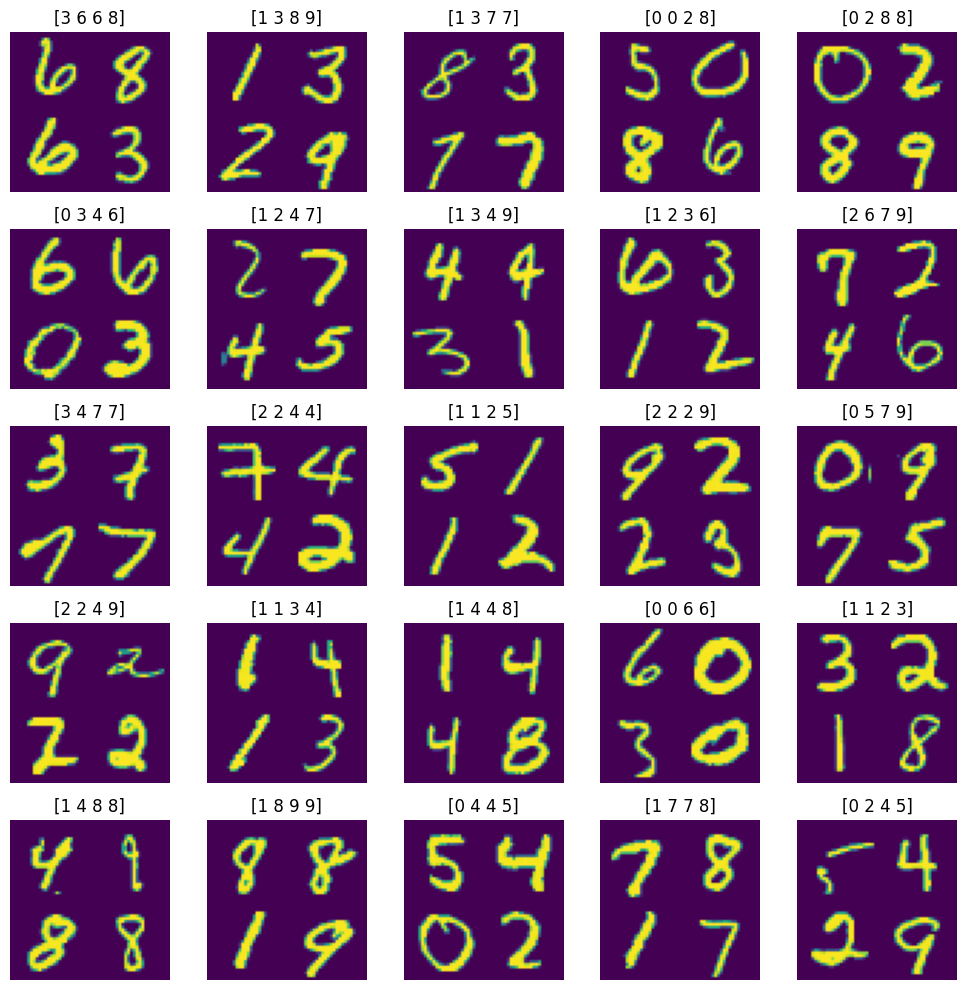

In [231]:
#--- To keep following outputs, do not run this cell! ---

In [232]:
final_accuary = np.mean(Y_hard_pred_final==Y_hard["test"])
final_accuary

In [232]:
#--- To keep following outputs, do not run this cell! ---

Array(0.732, dtype=float32)

In [3]:
(64*4)**3